# Loan Default Prediction

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
#from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
#from lightgbm import LGBMClassifier
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
data_descriptions = pd.read_csv('data_descriptions.csv')
pd.set_option('display.max_colwidth', None)
data_descriptions

,Column_name,Column_type,Data_type,Description
0,LoanID,Identifier,string,A unique identifier for each loan.
1,Age,Feature,integer,The age of the borrower.
2,Income,Feature,integer,The annual income of the borrower.
3,LoanAmount,Feature,integer,The amount of money being borrowed.
4,CreditScore,Feature,integer,"The credit score of the borrower, indicating their creditworthiness."
5,MonthsEmployed,Feature,integer,The number of months the borrower has been employed.
6,NumCreditLines,Feature,integer,The number of credit lines the borrower has open.
7,InterestRate,Feature,float,The interest rate for the loan.
8,LoanTerm,Feature,integer,The term length of the loan in months.
9,DTIRatio,Feature,float,"The Debt-to-Income ratio, indicating the borrower's debt compared to their income."


## Load the data

In [13]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
print(train_df.shape)
print(test_df.shape)

(255347, 18)
(109435, 17)


In [14]:
print(train_df.head())

       LoanID  Age  Income  LoanAmount  CreditScore  MonthsEmployed  \
0  I38PQUQS96   56   85994       50587          520              80   
1  HPSK72WA7R   69   50432      124440          458              15   
2  C1OZ6DPJ8Y   46   84208      129188          451              26   
3  V2KKSFM3UN   32   31713       44799          743               0   
4  EY08JDHTZP   60   20437        9139          633               8   

   NumCreditLines  InterestRate  LoanTerm  DTIRatio    Education  \
0               4         15.23        36      0.44   Bachelor's   
1               1          4.81        60      0.68     Master's   
2               3         21.17        24      0.31     Master's   
3               3          7.07        24      0.23  High School   
4               4          6.51        48      0.73   Bachelor's   

  EmploymentType MaritalStatus HasMortgage HasDependents LoanPurpose  \
0      Full-time      Divorced         Yes           Yes       Other   
1      Full-time    

## Data preprocessing and visualization 

### Check for missing values(none in both train_df and test_df)

In [15]:
print("Missing values:")
print(train_df.isnull().sum())
print(test_df.isnull().sum())

Missing values:
LoanID            0
Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64
LoanID            0
Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
dtype: int64


### Identify categorical and numerical features


In [16]:
categorical_features = ['Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner']
numerical_features = ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio']

### Default rate vs categorical features

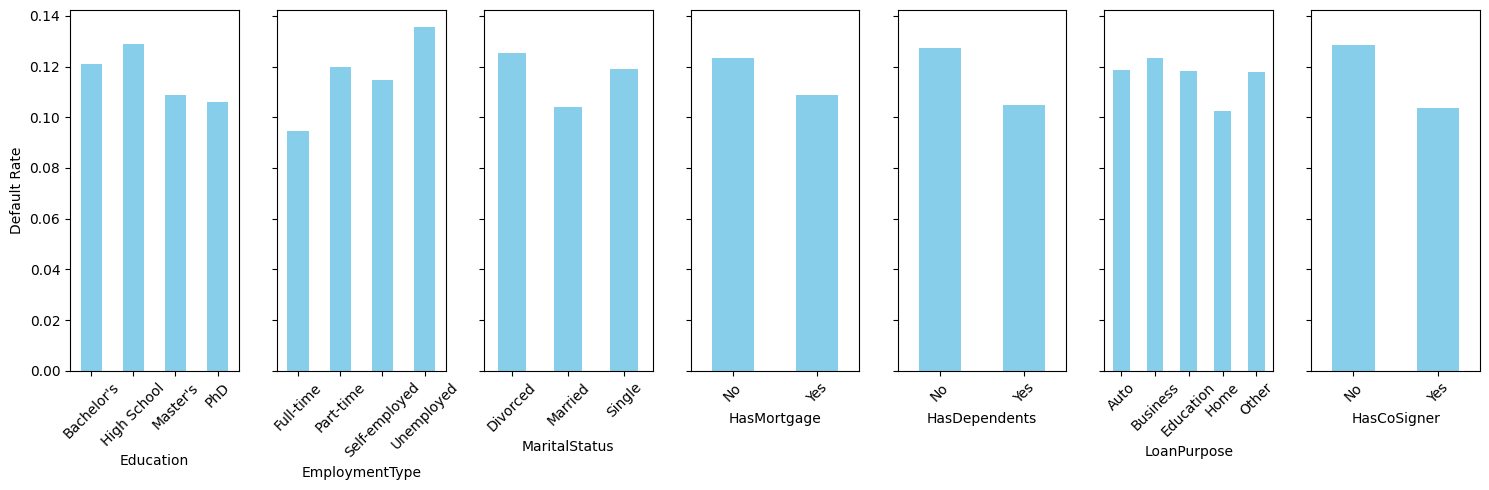

In [17]:
# Set up the matplotlib figure and axes
fig, axes = plt.subplots(nrows=1, ncols=len(categorical_features), figsize=(15, 5), sharey=True)

# Loop through the categorical features and create a bar plot for each
for ax, feature in zip(axes, categorical_features):
    # Calculate the default rates
    default_rates = train_df.groupby(feature)['Default'].mean()
    
    # Plot
    default_rates.plot(kind='bar', color='skyblue', ax=ax)
    #ax.set_title(f'Default Rates by {feature}')
    ax.set_xlabel(f'{feature}')
    ax.set_ylabel('Default Rate')
    ax.tick_params(axis='x', labelrotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

### Encode binary categorical features

In [18]:
binary_features = ['HasMortgage', 'HasDependents', 'HasCoSigner']

for feature in binary_features:
    train_df[feature] = train_df[feature].map({'Yes': 1, 'No': 0})
    #test_df[feature] = test_df[feature].map({'Yes': 1, 'No': 0})

### Encode non-binary categorical features

In [19]:
# Education levels are ordinal.
education_level = {
    "PhD": 3,
    "Master's": 2,
    "Bachelor's": 1,
    "High School": 0
}
train_df['Education'] = train_df['Education'].map(education_level) 

In [20]:
'''
education_level = {
    "PhD": 0,
    "Master's": 1,
    "Bachelor's": 2,
    "High School": 3
}
'''

'\neducation_level = {\n    "PhD": 0,\n    "Master\'s": 1,\n    "Bachelor\'s": 2,\n    "High School": 3\n}\n'

In [21]:
One_hot_features = ['EmploymentType','MaritalStatus','LoanPurpose']
train_df = pd.get_dummies(train_df, columns=One_hot_features)

### Handling outliers
Boosting algorithms such as XGBoost are extremely sensitive to outliers. Thus, outliers should be removed before the data are trained.

In [22]:
def treat_outliers(df,feature):
    '''
    feature: str
    df: data frame
    '''
    Q1 = np.nanquantile(df[feature], 0.25) 
    Q3 = np.nanquantile(df[feature], 0.75) 
    IQR = Q3 - Q1   # IQR Range
    Lower_Whisker = Q1 - 1.5*IQR  
    Upper_Whisker = Q3 + 1.5*IQR  
    df[feature] = np.clip(df[feature], Lower_Whisker, Upper_Whisker) # all the values samller than Lower_Whisker will be assigned value of Lower_whisker 
                                                            # and all the values above upper_whishker will be assigned value of upper_Whisker 
    return df

for f in numerical_features:
    train_df = treat_outliers(train_df,f)

In [23]:
train_df.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,...,EmploymentType_Self-employed,EmploymentType_Unemployed,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,LoanPurpose_Auto,LoanPurpose_Business,LoanPurpose_Education,LoanPurpose_Home,LoanPurpose_Other
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,...,0,0,1,0,0,0,0,0,0,1
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,...,0,0,0,1,0,0,0,0,0,1
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,...,0,1,1,0,0,1,0,0,0,0
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,...,0,0,0,1,0,0,1,0,0,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,...,0,1,1,0,0,1,0,0,0,0


In [24]:
X = train_df.drop(['Default', 'LoanID'], axis=1)
y = train_df['Default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=14,stratify=y)

### Class imbalance
In loan default prediction problem, one important issue is the class imbalance, as shown in the following histogram. In this project, we use ADASYN for the oversampling on the training data.

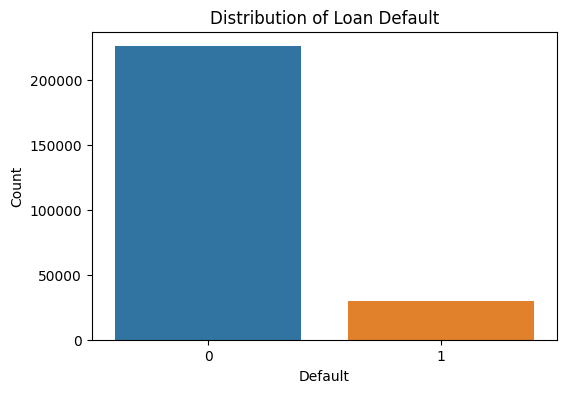

In [25]:
# Districbution of loan default
plt.figure(figsize=(6, 4))
sns.countplot(x='Default', data=train_df)
plt.title('Distribution of Loan Default')
plt.xlabel('Default')
plt.ylabel('Count')
plt.show()

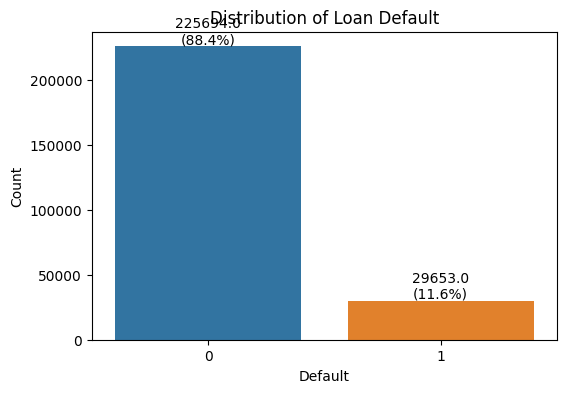

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of loan default
plt.figure(figsize=(6, 4))
sns.countplot(x='Default', data=train_df)

# Add count labels on the bars
def show_counts(ax, total=len(train_df)):
    for p in ax.patches:
        count = p.get_height()
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        percentage = '{:.1f}%'.format(100 * count / total)
        ax.annotate(f'{count}\n({percentage})', (x, y), ha='center', va='bottom')

show_counts(plt.gca())

plt.title('Distribution of Loan Default')
plt.xlabel('Default')
plt.ylabel('Count')
plt.show()

In [27]:
print(X_train.dtypes)

Age                               int64
Income                            int64
LoanAmount                        int64
CreditScore                       int64
MonthsEmployed                    int64
NumCreditLines                    int64
InterestRate                    float64
LoanTerm                          int64
DTIRatio                        float64
Education                         int64
HasMortgage                       int64
HasDependents                     int64
HasCoSigner                       int64
EmploymentType_Full-time          uint8
EmploymentType_Part-time          uint8
EmploymentType_Self-employed      uint8
EmploymentType_Unemployed         uint8
MaritalStatus_Divorced            uint8
MaritalStatus_Married             uint8
MaritalStatus_Single              uint8
LoanPurpose_Auto                  uint8
LoanPurpose_Business              uint8
LoanPurpose_Education             uint8
LoanPurpose_Home                  uint8
LoanPurpose_Other                 uint8


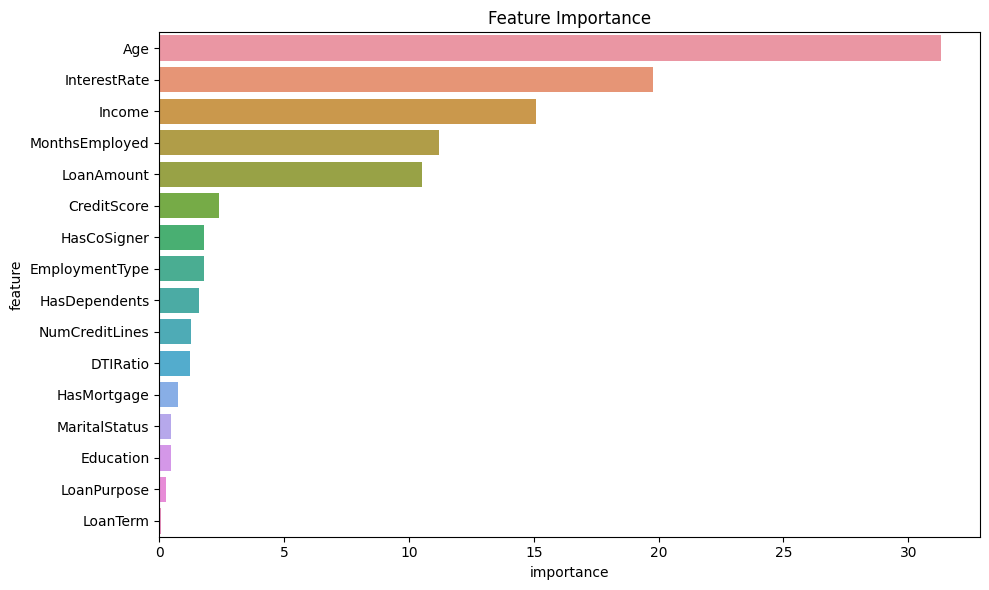

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier

# Load the saved model
model = CatBoostClassifier()
model.load_model('best_catboost_model.cbm')

# Get the feature names from the model
feature_names = model.feature_names_

# Get the feature importance
feature_importance = model.get_feature_importance()

# Create a DataFrame with feature names and importance
fi_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})

# Sort the DataFrame by importance
fi_df = fi_df.sort_values('importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=fi_df)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()